In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',50)

In [2]:
ht_df = pd.read_csv('hypertension_norm_data.csv')
ht_df.head()

,primaryid,caseid,drugname,pt,age,UMLS_pt,UMLS_drugname
0,57419732,5741973,atenolol,Barrett's oesophagus,77.0,Hematemesis,atenolol
1,57419732,5741973,atenolol,Haematemesis,77.0,Dyspnea,atenolol
2,57571695,5757169,hydralazine,Dyspnoea,52.0,Hallucinations,hydralazine
3,57571695,5757169,hydralazine,Hallucination,52.0,Impaired wound healing,hydralazine
4,57571695,5757169,hydralazine,Impaired healing,52.0,Multiple sclerosis relapse,hydralazine


In [3]:
drugname_counts = ht_df['UMLS_drugname'].value_counts()

In [4]:
# Filtering out drugnames with count less than 5
ht_df = ht_df[ht_df['UMLS_drugname'].isin(drugname_counts[drugname_counts >= 5].index)]
ht_df.head()

,primaryid,caseid,drugname,pt,age,UMLS_pt,UMLS_drugname
0,57419732,5741973,atenolol,Barrett's oesophagus,77.0,Hematemesis,atenolol
1,57419732,5741973,atenolol,Haematemesis,77.0,Dyspnea,atenolol
2,57571695,5757169,hydralazine,Dyspnoea,52.0,Hallucinations,hydralazine
3,57571695,5757169,hydralazine,Hallucination,52.0,Impaired wound healing,hydralazine
4,57571695,5757169,hydralazine,Impaired healing,52.0,Multiple sclerosis relapse,hydralazine


In [5]:
pt_counts = ht_df['UMLS_pt'].value_counts()

In [6]:
# Filtering out pts with count less than 5
ht_df = ht_df[ht_df['UMLS_pt'].isin(pt_counts[pt_counts >= 5].index)]
ht_df.head()

,primaryid,caseid,drugname,pt,age,UMLS_pt,UMLS_drugname
0,57419732,5741973,atenolol,Barrett's oesophagus,77.0,Hematemesis,atenolol
1,57419732,5741973,atenolol,Haematemesis,77.0,Dyspnea,atenolol
2,57571695,5757169,hydralazine,Dyspnoea,52.0,Hallucinations,hydralazine
3,57571695,5757169,hydralazine,Hallucination,52.0,Impaired wound healing,hydralazine
4,57571695,5757169,hydralazine,Impaired healing,52.0,Multiple sclerosis relapse,hydralazine


### Proportional Reporting Ratio (PRR)

In [7]:
# Add a count column
ht_df['count'] = 1

# Total number of reports
N = ht_df['count'].sum()

In [8]:
# Step 1: a = count where drug_name and pt co-occur
a = ht_df.groupby(['UMLS_drugname', 'UMLS_pt'])['count'].sum().reset_index(name='a')

In [9]:
# Step 2: b = count where drug_name matches, pt != current pt
drug_total = ht_df.groupby('UMLS_drugname')['count'].sum().reset_index(name='drug_total')
a = a.merge(drug_total, on='UMLS_drugname')
a['b'] = a['drug_total'] - a['a']

In [10]:
# Step 3: c = count where pt matches, drug != current drug
pt_total = ht_df.groupby('UMLS_pt')['count'].sum().reset_index(name='pt_total')
a = a.merge(pt_total, on='UMLS_pt')
a['c'] = a['pt_total'] - a['a']

In [11]:
# Step 4: d = everything else
a['d'] = N - (a['a'] + a['b'] + a['c'])

# Step 5: PRR calculation
a['PRR'] = (a['a'] / (a['a'] + a['c'])) / (a['b'] / (a['b'] + a['d']))

# Optional: Filter PRR > 3
prr_filtered = a[a['PRR'] > 3]

In [33]:
# Remove rare co-occurrences
prr_final = prr_filtered[(prr_filtered['a'] >= 3)]

In [21]:
prr_final.to_csv('prr_final.csv',index=False)

Which drugs have the most disproportionate reporting signals (high PRR counts)? Question: Which drugs are associated with the highest number of high-PRR signals?
Answer: We can rank the drugs by the number of PRR > 3 events (rows):

This tells you which drugs have the most diverse or frequent disproportionate adverse event signals.

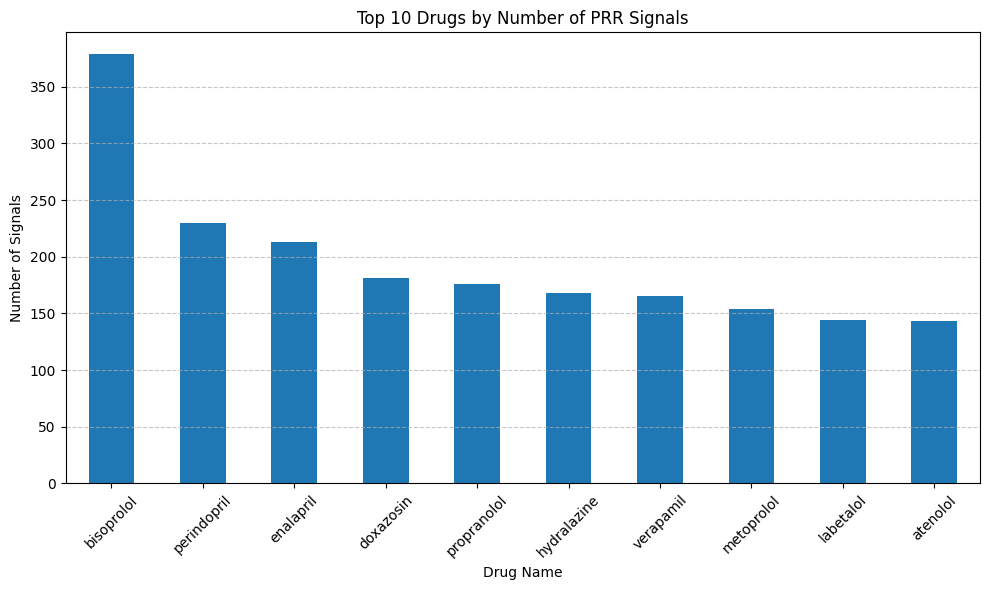

In [34]:
# Assuming `top_signal_drugs` is already defined:
top_signal_drugs = prr_final['UMLS_drugname'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
top_signal_drugs.plot(kind='bar')
plt.title('Top 10 Drugs by Number of PRR Signals')
plt.xlabel('Drug Name')
plt.ylabel('Number of Signals')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

What are the most frequently reported adverse events with high PRR? Question: What PTs (Preferred Terms) are disproportionately reported across multiple drugs? This helps identify adverse events that appear across drugs and may indicate systematic issues.

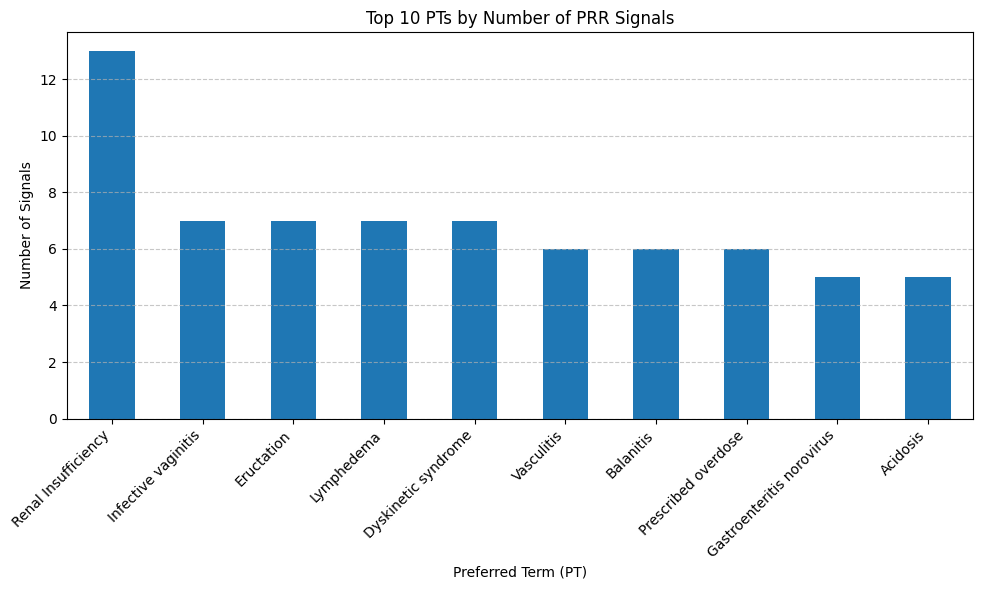

In [35]:
# Calculate top 10 PTs
top_signal_pts = prr_final['UMLS_pt'].value_counts().head(10)

# Plot
plt.figure(figsize=(10, 6))
top_signal_pts.plot(kind='bar')
plt.title('Top 10 PTs by Number of PRR Signals')
plt.xlabel('Preferred Term (PT)')
plt.ylabel('Number of Signals')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Are any drug-AE pairs especially concerning based on PRR magnitude? Question: Which drug–event combinations have the highest PRR values?
These combinations deserve special review as they are statistically most disproportionate.

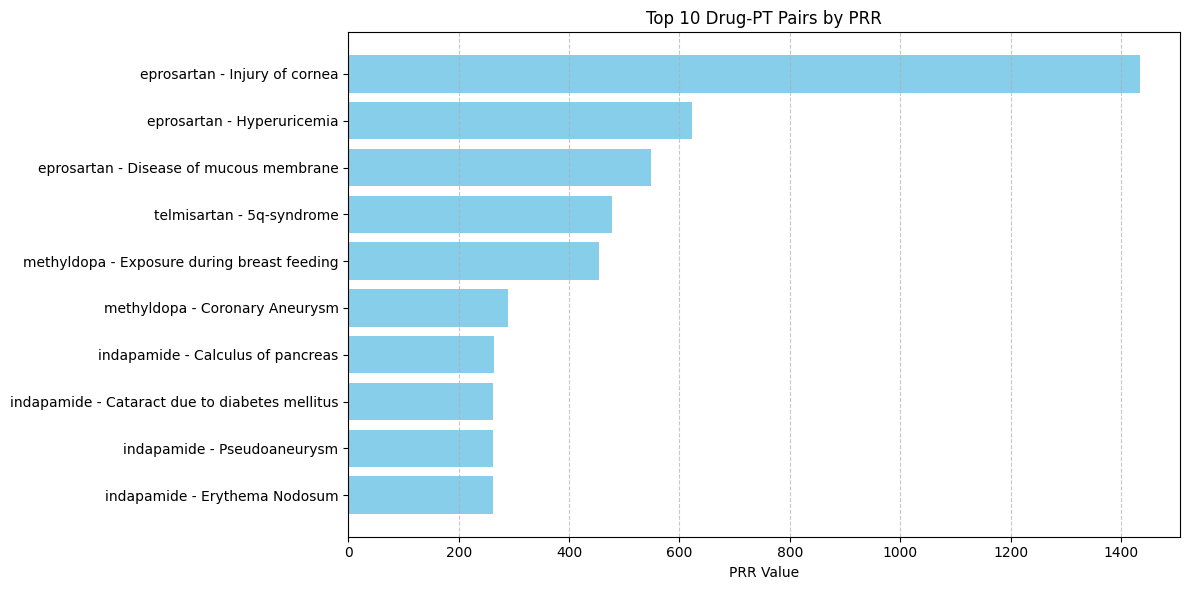

In [36]:
# Get top 10 PRR signals
top_prr_signals = prr_final.sort_values(by='PRR', ascending=False).head(10)

# Create labels for each bar
labels = top_prr_signals.apply(lambda row: f"{row['UMLS_drugname']} - {row['UMLS_pt']}", axis=1)

# Plot
plt.figure(figsize=(12, 6))
plt.barh(labels, top_prr_signals['PRR'], color='skyblue')
plt.xlabel('PRR Value')
plt.title('Top 10 Drug-PT Pairs by PRR')
plt.gca().invert_yaxis()  # Highest PRR on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Do specific drug classes (e.g., ACE inhibitors, beta-blockers) show more signals? Question: Can we see patterns in PRR signals across known drug classes?
Answer: You can map each drug to its pharmacological class and group by that class: This reveals if certain classes are overrepresented.

In [38]:
rare_but_high_prr = prr_final[(prr_final['a'] <= 5) & (prr_final['PRR'] > 100)]
rare_but_high_prr[['UMLS_drugname', 'UMLS_pt', 'a', 'PRR']]

,UMLS_drugname,UMLS_pt,a,PRR
17762,eprosartan,Disease of mucous membrane,4,548.869226
17778,eprosartan,Hyperuricemia,3,622.453517
17783,eprosartan,Injury of cornea,5,1434.765306
22250,indapamide,Cataract due to diabetes mellitus,4,262.984414
22278,indapamide,Decreased body weight,4,131.489713
22297,indapamide,Edema of mouth,3,105.061021
22303,indapamide,Erythema Nodosum,3,262.658157
22367,indapamide,"Intubation, Intratracheal",3,262.658157
22400,indapamide,Mechanical ventilation,3,112.565647
22451,indapamide,Pseudoaneurysm,3,262.658157


In [39]:
from tabulate import tabulate

# Display top N rare-but-high PRR signals as a clean table
top_rare_high_prr = rare_but_high_prr[['UMLS_drugname', 'UMLS_pt', 'a', 'PRR']].sort_values(by='PRR', ascending=False).head(15)

print(tabulate(top_rare_high_prr, headers='keys', tablefmt='pretty', showindex=False))

+---------------+-----------------------------------+---+--------------------+
| UMLS_drugname |              UMLS_pt              | a |        PRR         |
+---------------+-----------------------------------+---+--------------------+
|  eprosartan   |         Injury of cornea          | 5 | 1434.765306122449  |
|  eprosartan   |           Hyperuricemia           | 3 |  622.453516969995  |
|  eprosartan   |    Disease of mucous membrane     | 4 | 548.8692257644761  |
|  telmisartan  |            5q-syndrome            | 3 | 478.2630385487528  |
|  methyldopa   |  Exposure during breast feeding   | 3 | 454.22972002871495 |
|  methyldopa   |         Coronary Aneurysm         | 3 | 289.0525354042942  |
|  indapamide   | Cataract due to diabetes mellitus | 4 | 262.9844139650873  |
|  indapamide   |          Pseudoaneurysm           | 3 | 262.65815691158156 |
|  indapamide   |         Erythema Nodosum          | 3 | 262.65815691158156 |
|  indapamide   |     Intubation, Intratracheal     

Are rare events contributing to high PRRs disproportionately?
Question: Are there drug-event combinations with low a but still very high PRR?

In [40]:
rare_but_high_prr = prr_final[(prr_final['a'] <= 5) & (prr_final['PRR'] > 100)]
rare_but_high_prr[['UMLS_drugname', 'UMLS_pt', 'a', 'PRR']]

,UMLS_drugname,UMLS_pt,a,PRR
17762,eprosartan,Disease of mucous membrane,4,548.869226
17778,eprosartan,Hyperuricemia,3,622.453517
17783,eprosartan,Injury of cornea,5,1434.765306
22250,indapamide,Cataract due to diabetes mellitus,4,262.984414
22278,indapamide,Decreased body weight,4,131.489713
22297,indapamide,Edema of mouth,3,105.061021
22303,indapamide,Erythema Nodosum,3,262.658157
22367,indapamide,"Intubation, Intratracheal",3,262.658157
22400,indapamide,Mechanical ventilation,3,112.565647
22451,indapamide,Pseudoaneurysm,3,262.658157


### Association Rule Mining (ASM)

Before applying the association rule mining, we are going to select a sub-population (middle aged adults with Hypertension and having age between 40-59) and drop duplicated instances.

In [41]:
masks = (ht_df["age"] >= 40 ) & (ht_df["age"] <= 59)
masks.value_counts()

age
False    331993
True      89842
Name: count, dtype: int64

In [42]:
df_masked = ht_df[masks]
df_masked.shape

(89842, 8)

In [43]:
## Just to examine attributes' of duplicated instances
duplicateRowsDF = df_masked[df_masked.duplicated(["primaryid","caseid","UMLS_drugname","UMLS_pt"], keep = False)]

In [44]:
df_masked.drop_duplicates(subset=["primaryid","caseid","UMLS_drugname","UMLS_pt"], keep = "first", inplace = True)

In [45]:
baskets = []
num = 1
temp_basket = []
last_line = False
for index, row in df_masked.iterrows():
    ## check whether the new row is from the same patient or not
    ## If it is the same patient, the new row will be put into the same basket
    ## If not, create a new basket.
    if num == 1:
        previous_id = row["caseid"]
        current_id = row["caseid"]
        first_line = True
    elif num == df_masked.shape[0]:
        last_line = True
        first_line = False
        previous_id = current_id
        current_id = row["caseid"]
    else:
        first_line = False
        previous_id = current_id
        current_id = row["caseid"]
    ## if the new row is from the same patient, only add the adverse drug reaction
    if previous_id == current_id :
        same_patient = True
    else:
        same_patient = False
    if same_patient:
        temp_basket.append(row["UMLS_pt"])
        if first_line:
            temp_basket.append(row["UMLS_drugname"])
    else:
        baskets.append(temp_basket)
        temp_basket = []
        temp_basket.append(row["UMLS_drugname"])
        temp_basket.append(row["UMLS_pt"])
    if last_line:
        baskets.append(temp_basket)
    num += 1

In [46]:
len(baskets)

16305

In [47]:
baskets[2]

['amlodipine',
 'Intestinal Obstruction',
 'Peritoneal adhesion',
 'Foetal exposure during pregnancy',
 'Intestinal Obstruction',
 'Peritoneal adhesion',
 'Foetal exposure during pregnancy']

##### Preprocessing
Let's find some interesting associations between them!
Before starting the fun part, we need to preprocess the dataset. The library (MLXtend) requires 1/0 representation for attributes. With that being said, the shape of the dataframe should be changed. We need to check how many unique items are actually in the data.

In [48]:
items = list()
for basket in baskets:
    items.extend(basket)
print(set(items))
print(len(set(items)))

{'Infusion site infection', 'Peripheral artery restenosis', 'Lymphoma, Non-Hodgkin', 'Intracranial Aneurysm', 'Antiphospholipid antibodies positive', 'Intraabdominal hemorrhage', 'Prostate specific antigen above reference range', 'Pyloric Stenosis', 'Burning sensation of skin', 'Pancreatic enzymes increased', 'Therapeutic product effect decreased', 'Blood creatine phosphokinase abnormal', 'Polymenorrhea', 'Steroid withdrawal syndrome', 'Pruritus Ani', 'Intracranial Hemorrhage', 'Polycystic Ovary Syndrome', 'Cataract due to diabetes mellitus', 'Hematemesis', 'Disability', "Uhthoff's phenomenon", 'Subileus', 'Alopecia totalis', 'Electrocardiogram abnormal (finding)', 'Application site pain', 'Nerve injury', 'Hygroma, Subdural', 'Colorectal Carcinoma', 'Disturbance in thinking', 'Orbital swelling', 'Nail Diseases', 'Clostridium difficile infection', 'Streptococcal Infections', 'Non-infective meningitis', 'Hemorrhagic cerebral infarction', 'Ultrasound liver abnormal', 'Dehydration', 'Insti

As there are 3347 unique items, the number of columns should be 3347. In tuples, the values should represent whether each item occurs or not in the transaction. If an item is in the basket, it should be represented as 1. If not, it should be represented as 0.

In [49]:
# Create empty list to contain the converted data
converted_vals = []
for row in baskets:
    labels = {}
    # Find items that do not occur in the transaction
    not_occurred = list(set(items) - set(row))
    # Find items that occur in the transaction
    occurred = list(set(items).intersection(row))
    for nc in not_occurred:
        labels[nc] = 0
    for occ in occurred:
        labels[occ] = 1
    converted_vals.append(labels)

converted_basket = pd.DataFrame(converted_vals)
print(converted_basket.head())

   Infusion site infection  Peripheral artery restenosis  \
0                        0                             0   
1                        0                             0   
2                        0                             0   
3                        0                             0   
4                        0                             0   

   Lymphoma, Non-Hodgkin  Intracranial Aneurysm  \
0                      0                      0   
1                      0                      0   
2                      0                      0   
3                      0                      0   
4                      0                      0   

   Antiphospholipid antibodies positive  Intraabdominal hemorrhage  \
0                                     0                          0   
1                                     0                          0   
2                                     0                          0   
3                                     0             

##### Implementation
Now It's time for fun. You will create association rules between attributes. You need to change minimum support and/or other parameters to filter out less interesting rules

In [52]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

frequent_itemsets = apriori(converted_basket, min_support=0.3, use_colnames=True)

print(frequent_itemsets.head())

Empty DataFrame
Columns: [support, itemsets]
Index: []


In [53]:
frequent_itemsets = apriori(converted_basket, min_support=0.01, use_colnames=True)

print(frequent_itemsets)

      support                                           itemsets
0    0.022754                  (Clostridium difficile infection)
1    0.011408                                 (Ocular hyperemia)
2    0.010058                              (Pancreatitis, Acute)
3    0.022202                                 (Umbilical hernia)
4    0.021343                                      (propranolol)
..        ...                                                ...
129  0.010304      (Gastroesophageal reflux disease, lisinopril)
130  0.011960          (Bleeding from ear, Decrease in appetite)
131  0.012511      (Bleeding from ear, Herpes simplex infection)
132  0.014351              (Bleeding from ear, Hyperchlorhydria)
133  0.012328  (Increased frequency of defecation, Bleeding f...

[134 rows x 2 columns]


You got no frequent itemsets. You have relatively large transactions, so having high support is challenging. You have to tune this parameter to get a good number of candidates.

In [62]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(rules)

                                 antecedents  \
0                      (Urogenital Diseases)   
1                         (Umbilical hernia)   
2                      (Urogenital Diseases)   
3                               (amlodipine)   
4                      (Urogenital Diseases)   
5                                 (Seizures)   
6                               (amlodipine)   
7                               (Presyncope)   
8                                 (Seizures)   
9                               (amlodipine)   
10                              (amlodipine)   
11                      (Oropharyngeal pain)   
12                 (Periodontal destruction)   
13                              (amlodipine)   
14                    (Hypothermia, natural)   
15                              (amlodipine)   
16                               (Arthritis)   
17                              (amlodipine)   
18                              (amlodipine)   
19                (Herpes simplex infect

In [63]:
pd.set_option('display.max.rows',2000)

In [64]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Urogenital Diseases),(Umbilical hernia),0.027354,0.022202,0.011224,0.410314,18.481128,1.0,0.010616,1.658167,0.972492,0.292800,0.396925,0.457919
1,(Umbilical hernia),(Urogenital Diseases),0.022202,0.027354,0.011224,0.505525,18.481128,1.0,0.010616,1.967028,0.967368,0.292800,0.491619,0.457919
2,(Urogenital Diseases),(amlodipine),0.027354,0.358418,0.013063,0.477578,1.332464,1.0,0.003259,1.228093,0.256527,0.035050,0.185730,0.257013
3,(amlodipine),(Urogenital Diseases),0.358418,0.027354,0.013063,0.036448,1.332464,1.0,0.003259,1.009438,0.388899,0.035050,0.009350,0.257013
4,(Urogenital Diseases),(Seizures),0.027354,0.053971,0.013615,0.497758,9.222661,1.0,0.012139,1.883611,0.916645,0.201087,0.469105,0.375015
5,(Seizures),(Urogenital Diseases),0.053971,0.027354,0.013615,0.252273,9.222661,1.0,0.012139,1.300804,0.942436,0.201087,0.231245,0.375015
6,(amlodipine),(Presyncope),0.358418,0.026556,0.011224,0.031314,1.179163,1.0,0.001705,1.004912,0.236822,0.030030,0.004888,0.226973
7,(Presyncope),(amlodipine),0.026556,0.358418,0.011224,0.422633,1.179163,1.0,0.001705,1.111221,0.156086,0.030030,0.100089,0.226973
8,(Seizures),(amlodipine),0.053971,0.358418,0.022202,0.411364,1.147721,1.0,0.002858,1.089947,0.136051,0.056900,0.082524,0.236654
9,(amlodipine),(Seizures),0.358418,0.053971,0.022202,0.061944,1.147721,1.0,0.002858,1.008499,0.200611,0.056900,0.008428,0.236654


In [55]:
rules[ (rules['lift'] >= 2) & (rules['confidence'] >= 0.3) ].sort_values(by=['lift'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(Urogenital Diseases),(Umbilical hernia),0.027354,0.022202,0.011224,0.410314,18.481128,1.0,0.010616,1.658167,0.972492,0.292800,0.396925,0.457919
1,(Umbilical hernia),(Urogenital Diseases),0.022202,0.027354,0.011224,0.505525,18.481128,1.0,0.010616,1.967028,0.967368,0.292800,0.491619,0.457919
4,(Urogenital Diseases),(Seizures),0.027354,0.053971,0.013615,0.497758,9.222661,1.0,0.012139,1.883611,0.916645,0.201087,0.469105,0.375015
47,(Bleeding from ear),(Transitional cell carcinoma of bladder),0.065133,0.042625,0.022508,0.345574,8.107324,1.0,0.019732,1.462924,0.937732,0.264029,0.316438,0.436816
46,(Transitional cell carcinoma of bladder),(Bleeding from ear),0.042625,0.065133,0.022508,0.528058,8.107324,1.0,0.019732,1.980891,0.915686,0.264029,0.495177,0.436816
44,(Transitional cell carcinoma of bladder),(Hyperchlorhydria),0.042625,0.048206,0.015271,0.358273,7.432121,1.0,0.013217,1.483177,0.903981,0.202110,0.325771,0.337534
45,(Hyperchlorhydria),(Transitional cell carcinoma of bladder),0.048206,0.042625,0.015271,0.316794,7.432121,1.0,0.013217,1.401298,0.909282,0.202110,0.286376,0.337534
51,(Decrease in appetite),(Bleeding from ear),0.033609,0.065133,0.011960,0.355839,5.463241,1.0,0.009770,1.451294,0.845371,0.137809,0.310960,0.269728


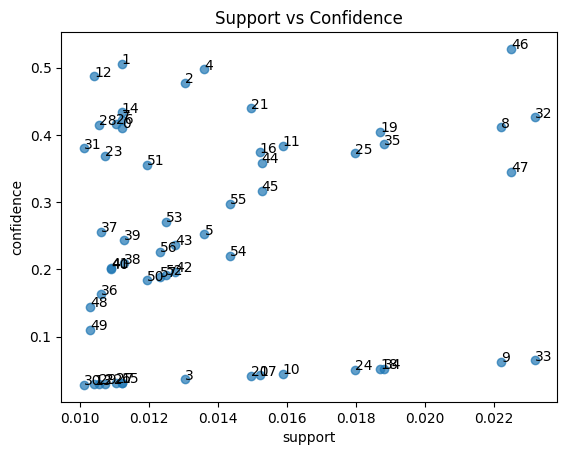

In [65]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.7)
for i in range(rules.shape[0]):
    plt.text(rules.loc[i,"support"], rules.loc[i,"confidence"], str(i))
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

Here’s a clinical-style interpretation of the top **drug antecedent rules** based on high lift and confidence:

---

### 🧪 Key Association Rule Interpretations (Drug → Condition)

#### 1. **Lisinopril → Gastroesophageal Reflux Disease**

* **Lift**: 1.54 | **Confidence**: 11% | **Support**: 1.0%
* **Interpretation**:

  * A mild but notable association between lisinopril use and GERD.
  * May suggest side effects such as cough or esophageal irritation leading to reflux symptoms.
  * Worth monitoring in hypertensive patients with GI symptoms.

#### 2. **Amlodipine → Periodontal Destruction**

* **Lift**: 1.36 | **Confidence**: 2.9% | **Support**: 1.0%
* **Interpretation**:

  * Potential link between amlodipine and gum/tissue issues.
  * Known side effect: gingival hyperplasia (gum overgrowth).
  * Could contribute to periodontal degradation if unmanaged.

#### 3. **Amlodipine → Urogenital Diseases**

* **Lift**: 1.33 | **Confidence**: 3.6% | **Support**: 1.3%
* **Interpretation**:

  * Low but measurable association.
  * May reflect side effects or downstream effects on renal/urogenital systems.
  * Suggests further inquiry into renal function interactions with calcium channel blockers.

#### 4. **Amlodipine → Skin Rash**

* **Lift**: 1.23 | **Confidence**: 4.2% | **Support**: 1.5%
* **Interpretation**:

  * Amlodipine may occasionally trigger dermatologic reactions.
  * Important to monitor for allergic or idiosyncratic responses.

#### 5. **Amlodipine → Hypothermia (Natural)**

* **Lift**: 1.21 | **Confidence**: 3.1% | **Support**: 1.1%
* **Interpretation**:

  * Unexpected and rare.
  * Could relate to peripheral vasodilation and altered thermoregulation.
  * Possibly spurious but worthy of post-market surveillance.

---
